<a href="https://colab.research.google.com/github/Monaa48/Hands-On-Machine-Learning-with-Scikit-Learn-Keras-and-TensorFlow/blob/main/notebooks/ch16_nlp_rnns_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 16 — Natural Language Processing with RNNs and Attention

## 1) Summary
In this chapter, I focus on **NLP pipelines and attention-based modeling**.

What I implement and document in this notebook:
- A practical **text classification** workflow using IMDB sentiment (binary classification).
- A clean baseline with **Embeddings + GRU**.
- Adding **attention pooling** on top of an RNN to reduce the “final hidden state bottleneck”.
- A compact **self-attention** model using `MultiHeadAttention`.
- A small **Transformer-style encoder block** (positional embeddings + self-attention + feed-forward).
- A minimal end-to-end **raw text → TextVectorization → model** demo to show the full preprocessing pipeline.

The goal is not to maximize accuracy, but to reproduce the chapter’s core ideas and show how each technique maps to code.

## 2) Learning Goals
- Build an NLP dataset pipeline (token IDs + padding/masking).
- Train an RNN-based sentiment classifier and read learning curves.
- Implement attention pooling and explain why it helps.
- Implement a small Transformer-like classifier and understand its main components.
- Keep preprocessing reproducible (TextVectorization inside the model).

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow:", tf.__version__)
print("GPU available:", bool(tf.config.list_physical_devices("GPU")))

TensorFlow: 2.19.0
GPU available: True


## 3) Core NLP Concepts (quick notes)

### 3.1 Tokenization → integer IDs
Neural networks consume numbers, so text must be mapped into sequences of integers:
- a vocabulary maps tokens → IDs
- each text sample becomes a variable-length sequence

### 3.2 Padding + masking
Because sequences have different lengths, we pad/truncate to a fixed length.
Padding tokens should be ignored by the model:
- `Embedding(mask_zero=True)` propagates a mask for padded zeros (ID=0).

### 3.3 Embeddings
An embedding layer maps each token ID to a dense vector.
This creates a sequence of vectors that RNNs and attention layers can process.

### 3.4 Attention intuition
Instead of compressing a whole sequence into one vector (e.g., final RNN state),
attention can learn to **weight** and combine information from all time steps.
This often helps with:
- long-range dependencies
- focusing on relevant tokens for the decision

### 3.5 Transformers
Transformer encoders rely on self-attention rather than recurrence.
Main building blocks:
- positional embeddings
- multi-head self-attention + residual + layer norm
- feed-forward network + residual + layer norm

# Part A — Dataset: IMDB Sentiment

## 4) Why IMDB here?
IMDB is a standard sentiment dataset and is available directly from Keras.
In this notebook it is provided as **sequences of token IDs** (already tokenized).
That is enough to reproduce the modeling parts of the chapter (RNNs + attention).

Workflow:
1. Load IMDB with a capped vocabulary size
2. Pad sequences to a fixed length
3. Train/validation split

In [13]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

vocab_size = 20000
max_len = 200

(X_train_all, y_train_all), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

# Changed padding from "pre" to "post" to resolve cuDNN incompatibility with masking
X_train_all = pad_sequences(X_train_all, maxlen=max_len, padding="post", truncating="pre")
X_test = pad_sequences(X_test, maxlen=max_len, padding="post", truncating="pre")

# Validation split
X_valid, X_train = X_train_all[:5000], X_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

X_train.shape, X_valid.shape, X_test.shape

((20000, 200), (5000, 200), (25000, 200))

In [14]:
def compile_fit_eval(model, X_train, y_train, X_valid, y_valid, X_test, y_test,
                     optimizer, epochs=3, batch_size=128, verbose=1):
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        verbose=verbose
    )
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    return history, float(test_acc)

def plot_history(history, title):
    df = pd.DataFrame(history.history)
    df[["loss", "val_loss"]].plot(figsize=(8, 4), grid=True, title=title + " — loss")
    plt.show()
    df[["accuracy", "val_accuracy"]].plot(figsize=(8, 4), grid=True, title=title + " — accuracy")
    plt.ylim(0, 1)
    plt.show()

# Part B — Baseline: Embedding + GRU

## 5) Baseline model
Architecture:
- Embedding(vocab_size, embed_dim, mask_zero=True)
- GRU(hidden_units)
- Dense(1, sigmoid)

Notes:
- GRU is often a strong baseline: simpler than LSTM but similar performance in many tasks.
- `mask_zero=True` is important because the dataset is padded.

In [15]:
embed_dim = 64

gru_baseline = keras.models.Sequential([
    keras.layers.Input(shape=(max_len,), dtype=tf.int32),
    keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True),
    keras.layers.GRU(64),
    keras.layers.Dense(1, activation="sigmoid")
])

gru_baseline.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 200, 64)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_6 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,305,025 (4.98 MB)

 Trainable params: 1,305,025 (4.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.6532 - loss: 0.5967 - val_accuracy: 0.8424 - val_loss: 0.3592
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8833 - loss: 0.2946 - val_accuracy: 0.8698 - val_loss: 0.3230
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9155 - loss: 0.2179 - val_accuracy: 0.8552 - val_loss: 0.3628


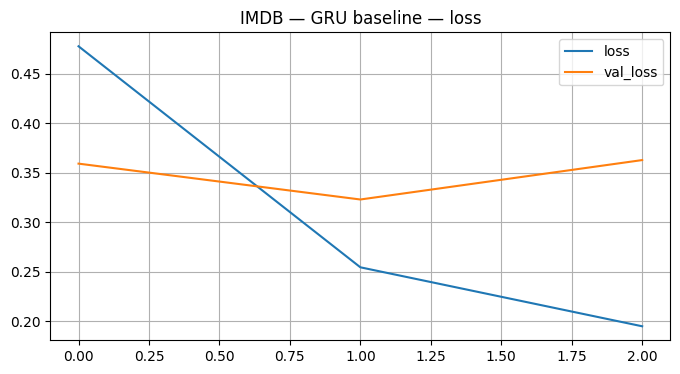

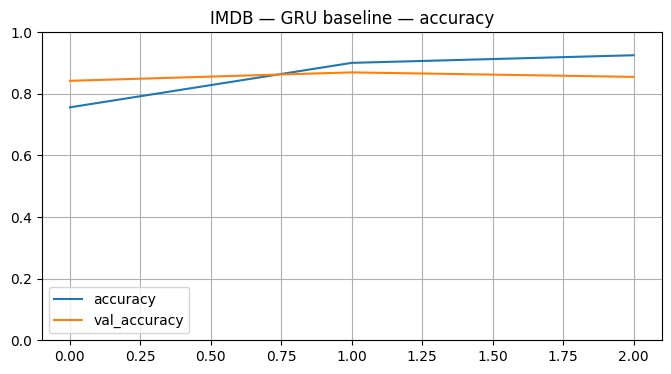

0.8511999845504761

In [16]:
hist_gru, acc_gru = compile_fit_eval(
    gru_baseline,
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    epochs=3,
    batch_size=128,
    verbose=1
)

plot_history(hist_gru, "IMDB — GRU baseline")
acc_gru

# Part C — Attention Pooling on top of an RNN

## 6) Why attention pooling?
If I take only the final RNN state, I force the model to compress the whole sequence into one vector.
Attention pooling instead learns a weighted summary of all time steps.

Implementation details:
- Use `return_sequences=True` so the RNN returns hidden states for each time step.
- Compute attention scores per time step (a small Dense layer).
- Apply softmax across time to get attention weights.
- Weighted sum of hidden states becomes the sequence representation.
- Mask padded tokens so padding does not attract attention weight.

In [17]:
class AttentionPooling(keras.layers.Layer):
    """Attention pooling over time steps.
    Input:  (batch, time, features)
    Output: (batch, features)
    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.score_dense = keras.layers.Dense(1)

    def call(self, inputs, mask=None):
        scores = self.score_dense(inputs)  # (batch, time, 1)
        if mask is not None:
            mask = tf.cast(mask[:, :, tf.newaxis], tf.float32)
            scores = scores + (1.0 - mask) * (-1e9)  # push padded steps to -inf
        weights = tf.nn.softmax(scores, axis=1)  # (batch, time, 1)
        return tf.reduce_sum(weights * inputs, axis=1)

# Build attention-RNN model (Functional API to keep masks)
inputs = keras.layers.Input(shape=(max_len,), dtype=tf.int32)
x = keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
x = keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True))(x)
x = AttentionPooling()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

attn_rnn_model = keras.Model(inputs, outputs)
attn_rnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attention_pooling_4' (of type AttentionPooling) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 200, 64)   │  1,280,000 │ input_layer_7[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 200)       │          0 │ input_layer_7[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 200, 128)  │     49,920 │ embedding_7[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_pooling_4 │ (None, 128)       │        129 │ bidirectional_4[… │
│ (AttentionPooling)  │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 64)        │      8,256 │ attention_poolin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 64)        │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 1)         │         65 │ dropout_4[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,338,370 (5.11 MB)

 Trainable params: 1,338,370 (5.11 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'attention_pooling_5' (of type AttentionPooling) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.7226 - loss: 0.5461 - val_accuracy: 0.8760 - val_loss: 0.3033
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9089 - loss: 0.2357 - val_accuracy: 0.8738 - val_loss: 0.3255
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.9458 - loss: 0.1582 - val_accuracy: 0.8712 - val_loss: 0.3351


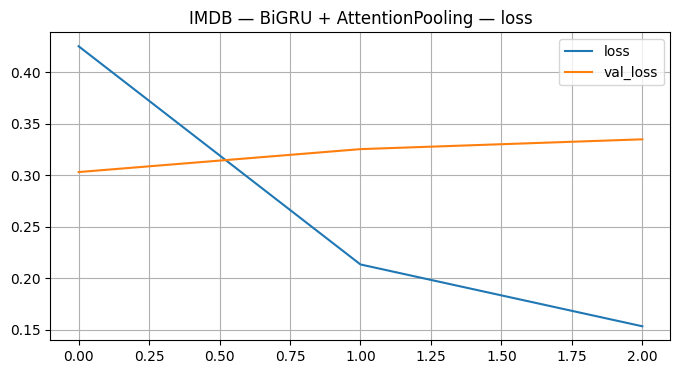

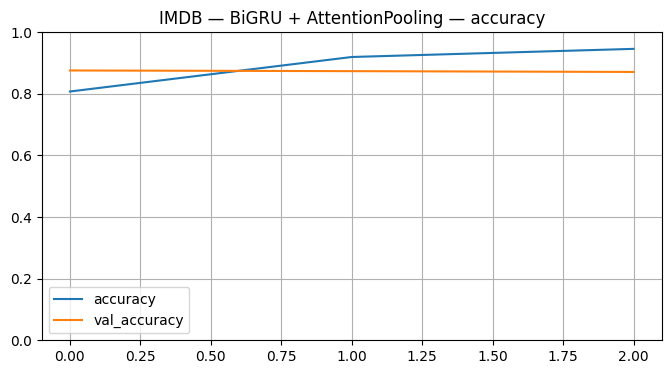

0.8533200025558472

In [18]:
# Re-build the model with use_cudnn=False to fix the padding/masking error
# We use the AttentionPooling class defined in the previous cell.
inputs = keras.layers.Input(shape=(max_len,), dtype=tf.int32)
x = keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inputs)
# use_cudnn=False is required when using masking with left-padding ('pre')
x = keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True, use_cudnn=False))(x)
x = AttentionPooling()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

attn_rnn_model = keras.Model(inputs, outputs)

hist_attn, acc_attn = compile_fit_eval(
    attn_rnn_model,
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    epochs=3,
    batch_size=128,
    verbose=1
)

plot_history(hist_attn, "IMDB — BiGRU + AttentionPooling")
acc_attn

# Part D — Self-Attention with MultiHeadAttention

## 7) Why self-attention?
Self-attention lets each token attend to other tokens directly.
Compared to RNNs:
- It can model long-range dependencies more directly.
- It is parallelizable across tokens (often faster for long sequences).

Here I implement a compact self-attention classifier:
- Embedding (masking)
- MultiHeadAttention (self-attention)
- pooling across time
- dense classifier head

Masking note:
`MultiHeadAttention` supports attention masks, but to keep this notebook robust across versions,
I compute an explicit mask from token IDs and pass it as `attention_mask`.

In [19]:
def make_attention_mask(token_ids):
    # token_ids: (batch, time), pad token is 0
    mask = tf.cast(tf.not_equal(token_ids, 0), tf.int32)  # (batch, time)
    # shape expected by MHA: (batch, query_len, key_len)
    return mask[:, tf.newaxis, :]  # broadcast over query_len

inputs = keras.layers.Input(shape=(max_len,), dtype=tf.int32)
x = keras.layers.Embedding(vocab_size, embed_dim)(inputs)

attn_mask = keras.layers.Lambda(make_attention_mask)(inputs)

attn_out = keras.layers.MultiHeadAttention(num_heads=4, key_dim=64, dropout=0.1)(
    x, x, attention_mask=attn_mask
)
x = keras.layers.Add()([x, attn_out])
x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

mha_model = keras.Model(inputs, outputs)
mha_model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, 200, 64)   │  1,280,000 │ input_layer_9[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1, 200)    │          0 │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     66,368 │ embedding_9[0][0… │
│ (MultiHeadAttentio… │                   │            │ embedding_9[0][0… │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 200, 64)   │          0 │ embedding_9[0][0… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 200, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_21 (Dense)    │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_21[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 1)         │         65 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,350,721 (5.15 MB)

 Trainable params: 1,350,721 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - accuracy: 0.7357 - loss: 0.5010 - val_accuracy: 0.8684 - val_loss: 0.3071
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.9175 - loss: 0.2169 - val_accuracy: 0.8796 - val_loss: 0.3275
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.9380 - loss: 0.1691 - val_accuracy: 0.8780 - val_loss: 0.3212


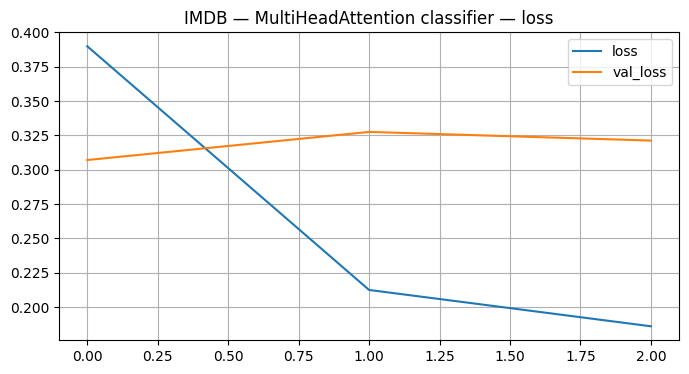

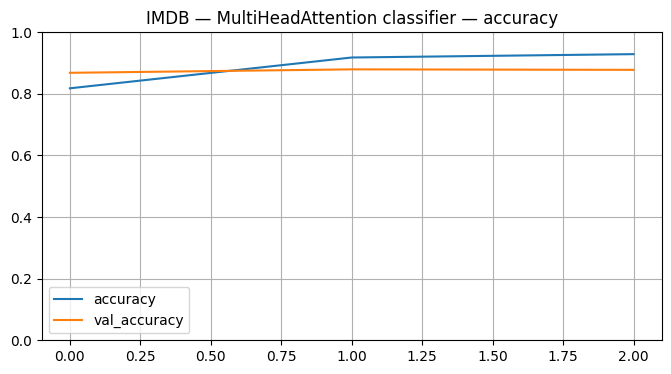

0.8614400029182434

In [20]:
hist_mha, acc_mha = compile_fit_eval(
    mha_model,
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    epochs=3,
    batch_size=128,
    verbose=1
)

plot_history(hist_mha, "IMDB — MultiHeadAttention classifier")
acc_mha

# Part E — Transformer-style Encoder Block

## 8) Transformer encoder block (compact)
A minimal encoder block includes:
- self-attention
- residual connection + layer norm
- feed-forward network
- residual connection + layer norm

I also add learned positional embeddings so the model knows token positions.

In [21]:
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = keras.layers.Embedding(vocab_size, embed_dim)
        self.pos_emb = keras.layers.Embedding(max_len, embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[-1], delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

def transformer_encoder_block(x, attn_mask, embed_dim, num_heads=4, ff_dim=128, dropout=0.1):
    attn_out = keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=64, dropout=dropout)(
        x, x, attention_mask=attn_mask
    )
    x = keras.layers.Add()([x, attn_out])
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)

    ff = keras.layers.Dense(ff_dim, activation="relu")(x)
    ff = keras.layers.Dropout(dropout)(ff)
    ff = keras.layers.Dense(embed_dim)(ff)
    x = keras.layers.Add()([x, ff])
    x = keras.layers.LayerNormalization(epsilon=1e-6)(x)
    return x

In [22]:
inputs = keras.layers.Input(shape=(max_len,), dtype=tf.int32)
attn_mask = keras.layers.Lambda(make_attention_mask)(inputs)

x = PositionalEmbedding(max_len=max_len, vocab_size=vocab_size, embed_dim=embed_dim)(inputs)
x = transformer_encoder_block(x, attn_mask, embed_dim=embed_dim, num_heads=4, ff_dim=128, dropout=0.1)

x = keras.layers.GlobalAveragePooling1D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(64, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(1, activation="sigmoid")(x)

transformer_model = keras.Model(inputs, outputs)
transformer_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 200)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 200, 64)   │  1,292,800 │ input_layer_10[0… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1, 200)    │          0 │ input_layer_10[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 200, 64)   │     66,368 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
│                     │                   │            │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 200, 64)   │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 200, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 200, 128)  │          0 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 200, 64)   │      8,256 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 200, 64)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 200, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 64)        │          0 │ global_average_p… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 64)        │      4,160 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64)        │          0 │ dense_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 1)         │         65 │ dropout_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,380,225 (5.27 MB)

 Trainable params: 1,380,225 (5.27 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 17s 58ms/step - accuracy: 0.6620 - loss: 0.5691 - val_accuracy: 0.8782 - val_loss: 0.2889
Epoch 2/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9040 - loss: 0.2460 - val_accuracy: 0.8808 - val_loss: 0.2853
Epoch 3/3
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9268 - loss: 0.1984 - val_accuracy: 0.8582 - val_loss: 0.3502


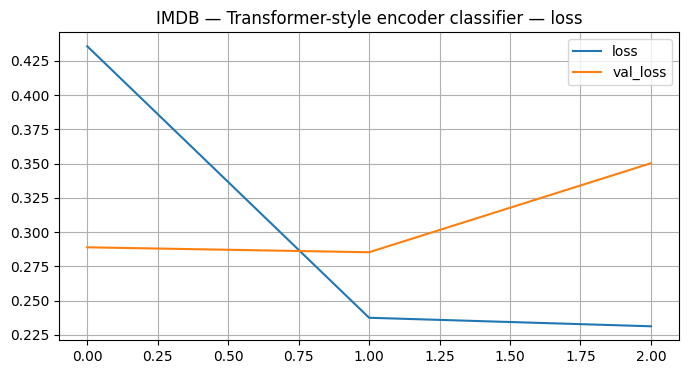

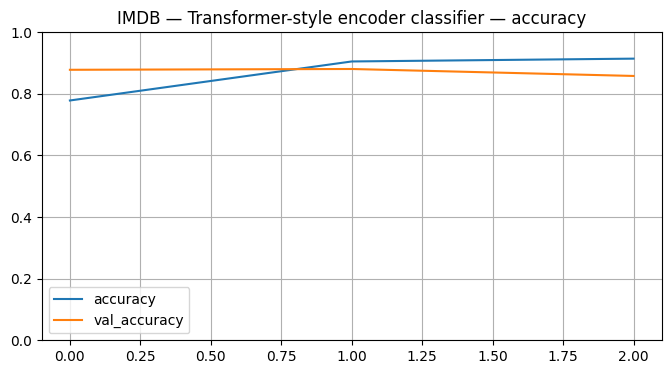

0.8420000076293945

In [23]:
hist_tr, acc_tr = compile_fit_eval(
    transformer_model,
    X_train, y_train,
    X_valid, y_valid,
    X_test, y_test,
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    epochs=3,
    batch_size=128,
    verbose=1
)

plot_history(hist_tr, "IMDB — Transformer-style encoder classifier")
acc_tr

## 9) Comparison table (same training budget)
This is a quick comparison under the same small training budget (few epochs).
If I wanted a stronger comparison, I would tune hyperparameters and train longer.

In [24]:
results = pd.DataFrame([
    {"model": "GRU baseline", "test_accuracy": acc_gru},
    {"model": "BiGRU + AttentionPooling", "test_accuracy": acc_attn},
    {"model": "MultiHeadAttention", "test_accuracy": acc_mha},
    {"model": "Transformer-style encoder", "test_accuracy": acc_tr},
]).sort_values("test_accuracy", ascending=False)

results

,model,test_accuracy
2,MultiHeadAttention,0.86144
1,BiGRU + AttentionPooling,0.85332
0,GRU baseline,0.85120
3,Transformer-style encoder,0.84200


# Part F — Raw text pipeline demo (TextVectorization)

## 10) Why include this?
In real NLP tasks, I usually start from raw text, not pre-tokenized sequences.
To keep this notebook runnable without downloading extra datasets,
I demonstrate the full pipeline using a small custom text set:

raw text → TextVectorization → Embedding → GRU → classifier

The important point:
`TextVectorization` can live inside the model, so preprocessing is saved and reused at inference time.

In [25]:
raw_texts = tf.constant([
    "This movie was fantastic and I loved it",
    "Terrible film, boring and too long",
    "Great acting but the story was weak",
    "I would not recommend this movie",
    "Absolutely wonderful experience",
    "The plot was confusing and the acting was awful",
    "I enjoyed it, great vibes and good pacing",
    "Worst movie ever"
], dtype=tf.string)

raw_labels = tf.constant([1, 0, 1, 0, 1, 0, 1, 0], dtype=tf.int32)

vectorizer = keras.layers.TextVectorization(
    max_tokens=2000,
    output_mode="int",
    output_sequence_length=30
)
vectorizer.adapt(raw_texts)

tiny_text_model = keras.models.Sequential([
    keras.layers.Input(shape=(1,), dtype=tf.string),
    vectorizer,
    keras.layers.Embedding(2000, 32, mask_zero=True),
    keras.layers.GRU(32),
    keras.layers.Dense(1, activation="sigmoid")
])

tiny_text_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
_ = tiny_text_model.fit(raw_texts, raw_labels, epochs=40, verbose=0)

tiny_text_model.predict(tf.constant(["I loved this wonderful film"], dtype=tf.string), verbose=0)

array([[0.5102559]], dtype=float32)

## 11) Takeaways
- Embeddings turn token IDs into dense vectors that models can learn from.
- RNNs (GRU/LSTM) are strong baselines, but attention often helps for selective focus and long-range relations.
- Multi-head self-attention provides a parallel, flexible way to relate tokens.
- Transformer-style encoder blocks combine self-attention + feed-forward layers with residual connections and normalization.
- Keeping preprocessing inside the model (TextVectorization, etc.) reduces train/inference mismatch.

## 12) References
- Aurélien Géron, *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*, Chapter 16.
- TensorFlow/Keras docs: Embedding, GRU/LSTM, MultiHeadAttention, TextVectorization, masking.